In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from copy import deepcopy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

### Get and Prepare Data

In [2]:
## Get Data (Note this cell can be skipped if Unzipped Dataset Folder is Present in current Directory)
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip "UCI HAR Dataset.zip"

--2023-05-07 15:18:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  32.3MB/s    in 1.8s    

2023-05-07 15:18:03 (32.3 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  infl

In [2]:
## Load Data
root = 'UCI HAR Dataset'
files = ["total_acc_x", "total_acc_y", "total_acc_z",
               "body_acc_x", "body_acc_y", "body_acc_z", 
               "body_gyro_x", "body_gyro_y", "body_gyro_z"]

def load(dataset):
    X_data = []
    for file in files:
        filename = f'{root}/{dataset}/Inertial Signals/{file}_{dataset}.txt'
        X_data.append(np.array(pd.read_csv(filename, delim_whitespace=True, header=None)))
    X_data = np.transpose(X_data, (1, 2, 0))

    filename = f'{root}/{dataset}/y_{dataset}.txt'
    y_data = np.array(pd.read_csv(filename, delim_whitespace=True, header=None)[0])
    
    return X_data, y_data


X_train, y_train = load('train')
X_test, y_test = load('test')

In [3]:
## Create a small Val Set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1000)

## Check the Data Length
print("X_train:", X_train.shape, "\ty_train:", y_train.shape)
print("X_val:", X_val.shape, "\ty_val:", y_val.shape)
print("X_test:", X_test.shape, "\ty_test:", y_test.shape)

X_train: (6352, 128, 9) 	y_train: (6352,)
X_val: (1000, 128, 9) 	y_val: (1000,)
X_test: (2947, 128, 9) 	y_test: (2947,)


In [4]:
## Now we create the TensorDatasets and Dataloaders
lb = LabelBinarizer().fit(y_train)
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(lb.transform(y_train)))
val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(lb.transform(y_val)))
# test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)) 

batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=2)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, num_workers=2)
# test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, num_workers=2)

## Create LSTM and GRU Models

In [3]:
class HAR_LSTM(nn.Module):
    def __init__(self, x_dim=9, h_dim=64, num_classes=6):
        super(HAR_LSTM, self).__init__()
        ## The LSTM will be used to learn temporal relations
        self.lstm = nn.LSTM(x_dim, h_dim, batch_first=True)
        ## We have a multiclass classification task, with the lstm outputs we will train a Fully Connected Network
        self.clf = nn.Sequential(nn.Linear(h_dim, h_dim // 2),
                                 nn.ReLU(), 
                                 nn.Linear(h_dim // 2, num_classes))
    
    def forward(self, X):
        lstm_out, _ = self.lstm(X)
        clf_out = self.clf(lstm_out[:,-1,:]) # We want to predict based on the output of the last LSTM cell
        return clf_out

    def predict(self, X):
        har_out = torch.softmax(self.forward(X), dim=1)
        return torch.argmax(har_out, dim=1) + 1 # The Plus one takes care of labels starting from 1

class HAR_GRU(nn.Module):
    def __init__(self, x_dim=9, h_dim=64, num_classes=6):
        super(HAR_GRU, self).__init__()
        ## The GRU will be used to learn temporal relations
        self.gru = nn.GRU(x_dim, h_dim, batch_first=True)
        ## We have a multiclass classification task, with the gru outputs we will train a Fully Connected Network
        self.clf = nn.Sequential(nn.Linear(h_dim, h_dim // 2),
                                 nn.ReLU(), 
                                 nn.Linear(h_dim // 2, num_classes))
    
    def forward(self, X):
        gru_out, _ = self.gru(X)
        clf_out = self.clf(gru_out[:,-1,:]) # We want to predict based on the output of the last GRU cell
        return clf_out

    def predict(self, X):
        har_out = torch.softmax(self.forward(X), dim=1)
        return torch.argmax(har_out, dim=1) + 1 # The Plus one takes care of labels starting from 1

## Train the Models

In [6]:
## Check Training Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Training on", device)

Training on cpu


In [7]:
## Training Code
def train_model(model, criterion, optimizer, epochs=20):
    train_loss = []
    val_loss = []
    best_val_loss = 1e10
    best_model = None
    model.to(device)
    model.float()    
    model.train()
    for epoch in range(epochs):
        out_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            # print(type(X), type(y))    
            out = model(X.float())
            loss = criterion(out, y.float())
            out_loss += loss.cpu().data.item() # Keep track of total training loss
            loss.backward() # Calculate gradients
            optimizer.step() # Take one gradient descent step
        
        train_loss.append(out_loss/len(train_loader))
        with torch.no_grad(): ## For evaluation on validation set
            out_loss = 0
            for X, y in val_loader:
                X, y = X.to(device), y.to(device) 
                out = model(X)
                loss = criterion(out, y.type(torch.float))
                out_loss += loss.cpu().data.item() # Keep track of total validation loss
            val_loss.append(out_loss/len(val_loader))

            ## Update best model based on validation error
            if val_loss[-1] < best_val_loss:
                best_val_loss = val_loss[-1]
                best_model = deepcopy(model.cpu().state_dict())
                model.to(device)
        print(f"Epoch: {epoch+1} | Training Loss: {train_loss[-1]} | Validation Loss: {val_loss[-1]}")
    
    return train_loss, val_loss, best_val_loss, best_model

In [8]:
criterion = nn.CrossEntropyLoss()
x_dim = X_train.shape[2]
num_classes = len(lb.classes_)

In [28]:
## LSTM
lstm_model = HAR_LSTM(x_dim, num_classes)
optimizer1 = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
train_loss_lstm, val_loss_lstm, best_val_loss_lstm, best_model_lstm = train_model(lstm_model, criterion, optimizer1, epochs=30)

Epoch: 1 | Training Loss: 1.75559774518013 | Validation Loss: 1.617890626192093
Epoch: 2 | Training Loss: 1.4797371470928191 | Validation Loss: 1.3334449604153633
Epoch: 3 | Training Loss: 1.0997703301906585 | Validation Loss: 0.8768646754324436
Epoch: 4 | Training Loss: 0.7582727128267288 | Validation Loss: 0.7127778120338917
Epoch: 5 | Training Loss: 0.6919446176290512 | Validation Loss: 0.676414992660284
Epoch: 6 | Training Loss: 0.6644707632064819 | Validation Loss: 0.6577923633158207
Epoch: 7 | Training Loss: 0.6331372129917144 | Validation Loss: 0.5958375334739685
Epoch: 8 | Training Loss: 0.5446249416470528 | Validation Loss: 0.48585208505392075
Epoch: 9 | Training Loss: 0.4052833154797554 | Validation Loss: 0.3349020602181554
Epoch: 10 | Training Loss: 0.2944891029596329 | Validation Loss: 0.220020049251616
Epoch: 11 | Training Loss: 0.2499835864454508 | Validation Loss: 0.2595354141667485
Epoch: 12 | Training Loss: 0.20742435164749623 | Validation Loss: 0.16229745652526617
Epo

In [19]:
## GRU
gru_model = HAR_GRU(x_dim, num_classes)
optimizer2 = torch.optim.Adam(gru_model.parameters(), lr=0.01)
train_loss_gru, val_loss_gru, best_val_loss_gru, best_model_gru = train_model(gru_model, criterion, optimizer2, epochs=30)

Epoch: 1 | Training Loss: 1.5979495632648468 | Validation Loss: 1.3516845256090164
Epoch: 2 | Training Loss: 1.036331222653389 | Validation Loss: 0.7224176339805126
Epoch: 3 | Training Loss: 0.6031635427474975 | Validation Loss: 0.4867257736623287
Epoch: 4 | Training Loss: 0.46964656084775924 | Validation Loss: 0.4752781819552183
Epoch: 5 | Training Loss: 0.42032112687826156 | Validation Loss: 0.3802284710109234
Epoch: 6 | Training Loss: 0.38633702546358106 | Validation Loss: 0.33709212578833103
Epoch: 7 | Training Loss: 0.313020893484354 | Validation Loss: 0.28042473178356886
Epoch: 8 | Training Loss: 0.26324799910187724 | Validation Loss: 0.25496432464569807
Epoch: 9 | Training Loss: 0.2342421169579029 | Validation Loss: 0.21562725398689508
Epoch: 10 | Training Loss: 0.247897846698761 | Validation Loss: 0.239619679749012
Epoch: 11 | Training Loss: 0.19996032908558845 | Validation Loss: 0.2068241904489696
Epoch: 12 | Training Loss: 0.1810950082540512 | Validation Loss: 0.1615104875527

## Plots and Results

In [29]:
lstm_model.cpu().load_state_dict(best_model_lstm)
gru_model.cpu().load_state_dict(best_model_gru)
X_test_tensor = torch.from_numpy(X_test).float()
display_labels = ['laying', 'sitting', 'standing', 'walking', 'walk_up', 'walk_down']

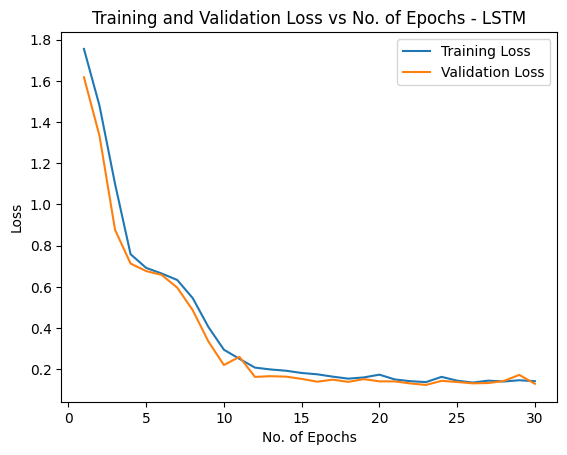

In [30]:
## Validation vs Training Loss Plot for LSTM
plt.plot([*range(1,31)], train_loss_lstm, label="Training Loss")
plt.plot([*range(1,31)], val_loss_lstm, label="Validation Loss")
plt.title("Training and Validation Loss vs No. of Epochs - LSTM")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [31]:
lstm_preds = lstm_model.predict(X_test_tensor).cpu().numpy()
print(classification_report(y_test, lstm_preds))
# lstm_preds

              precision    recall  f1-score   support

           1       0.85      0.89      0.87       496
           2       0.88      0.84      0.86       471
           3       0.89      0.95      0.92       420
           4       0.79      0.77      0.78       491
           5       0.80      0.83      0.81       532
           6       1.00      0.92      0.96       537

    accuracy                           0.87      2947
   macro avg       0.87      0.87      0.87      2947
weighted avg       0.87      0.87      0.87      2947



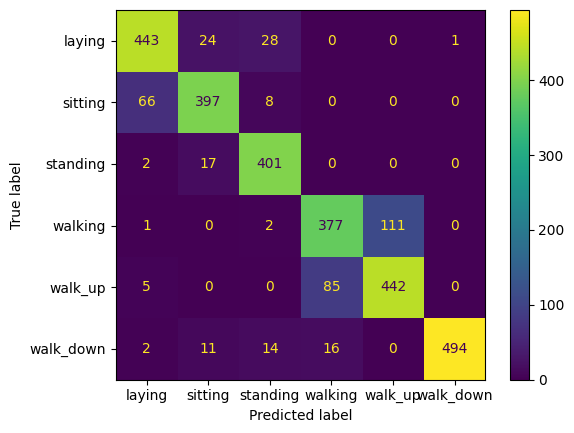

In [34]:
ConfusionMatrixDisplay(confusion_matrix(y_test, lstm_preds), display_labels=display_labels).plot()
plt.show()

In [33]:
## Save LSTM Model State Dict
torch.save(best_model_lstm, '/content/drive/MyDrive/Human Activity Classifiication/lstm_model.pt')

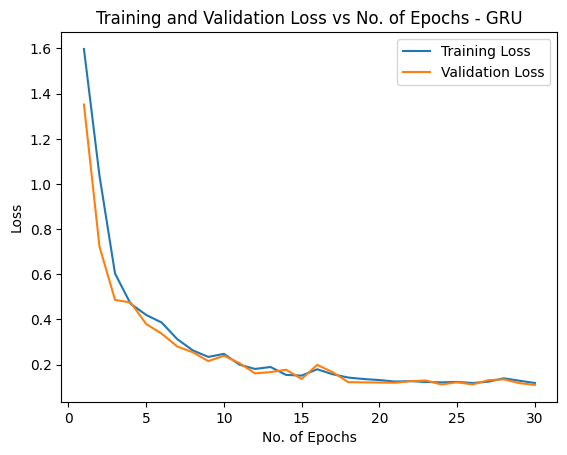

In [24]:
## Validation vs Training Loss Plot for GRU
plt.plot([*range(1,31)], train_loss_gru, label="Training Loss")
plt.plot([*range(1,31)], val_loss_gru, label="Validation Loss")
plt.title("Training and Validation Loss vs No. of Epochs - GRU")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
gru_preds = gru_model.predict(X_test_tensor).cpu().numpy()
print(classification_report(y_test, gru_preds))

              precision    recall  f1-score   support

           1       0.93      0.89      0.91       496
           2       0.86      0.87      0.86       471
           3       0.90      0.94      0.92       420
           4       0.82      0.79      0.81       491
           5       0.81      0.85      0.83       532
           6       1.00      0.99      1.00       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



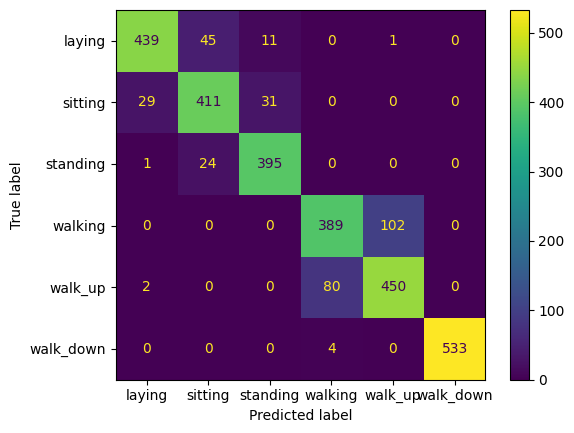

In [35]:
ConfusionMatrixDisplay(confusion_matrix(y_test, gru_preds), display_labels=display_labels).plot()
plt.show()

In [27]:
## Save GRU Model State Dict
torch.save(best_model_gru, '/content/drive/MyDrive/Human Activity Classifiication/gru_model.pt')

## Only Inference 
(Can be run by loading the saved model checkpoints - files assumed to be in current directory, update path for other cases)  
Note: Data loading and split creations done above need to be done before inference 

In [ ]:
X_test_tensor = torch.from_numpy(X_test).float()
display_labels = ['laying', 'sitting', 'standing', 'walking', 'walk_up', 'walk_down']

In [ ]:
## For LSTM
lstm_model_path = 'lstm_model.pt'
lstm_model = HAR_LSTM()
lstm_model.load_state_dict(torch.load(lstm_model_path))

lstm_preds = lstm_model.predict(X_test_tensor).cpu().numpy()
print(classification_report(y_test, lstm_preds))
ConfusionMatrixDisplay(confusion_matrix(y_test, lstm_preds), display_labels=display_labels).plot()
plt.show()

In [ ]:
## For GRU 
gru_model_path = 'lstm_model.pt'
gru_model = HAR_GRU()
gru_model.load_state_dict(torch.load(gru_model_path))

gru_preds = gru_model.predict(X_test_tensor).cpu().numpy()
print(classification_report(y_test, gru_preds))
ConfusionMatrixDisplay(confusion_matrix(y_test, gru_preds), display_labels=display_labels).plot()
plt.show()